In [2]:
import math
import pandas_datareader as web
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras
import yfinance as yf 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

#!pip install yfinance

plt.style.use('fivethirtyeight')

In [4]:
# Get the stock quote from July 2015 to December 2020
# Pulled data from Yahoo Finance
df = yf.download("TSLA", start="2015-01-01", end="2022-11-15")
# df = web.DataReader('TSLA', data_source = 'yahoo', start = '2015-01-01', end = '2021-01-05' )
print('Number of rows and columns: ', df.shape)
print(df.head())
print("checking if any null values are present\n", df.isna().sum())

[*********************100%***********************]  1 of 1 completed
Number of rows and columns:  (1982, 6)
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2015-01-02  14.858000  14.883333  14.217333  14.620667  14.620667  71466000
2015-01-05  14.303333  14.433333  13.810667  14.006000  14.006000  80527500
2015-01-06  14.004000  14.280000  13.614000  14.085333  14.085333  93928500
2015-01-07  14.223333  14.318667  13.985333  14.063333  14.063333  44526000
2015-01-08  14.187333  14.253333  14.000667  14.041333  14.041333  51637500
checking if any null values are present
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


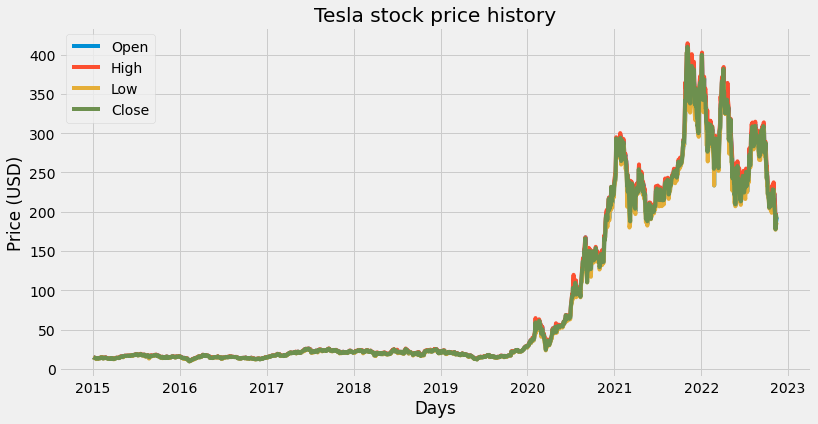

In [5]:
plt.figure(figsize = (12,6))
plt.plot(df["Open"])
plt.plot(df["High"])
plt.plot(df["Low"])
plt.plot(df["Close"])
plt.title('Tesla stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

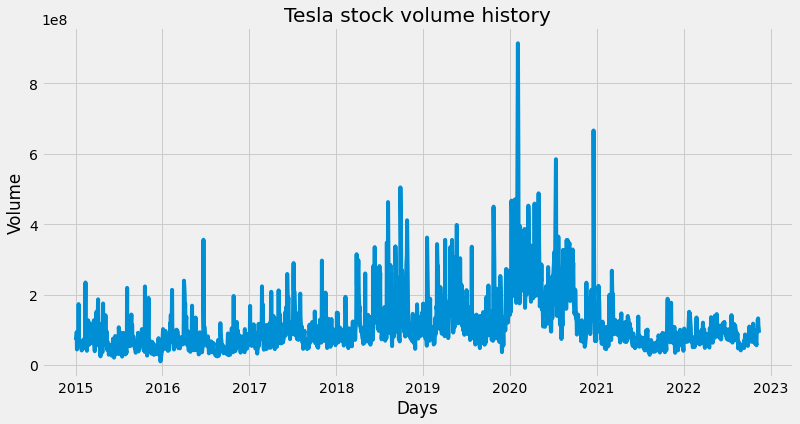

In [6]:
plt.figure(figsize = (12,6))
plt.plot(df["Volume"])
plt.title('Tesla stock volume history')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.show()

In [7]:
# Create a dataframe with only the Close Stock Price Column
data_target = df.filter(['Close'])

# Convert the dataframe to a numpy array to train the LSTM model
target = data_target.values

# Splitting the dataset into training and test
# Target Variable: Close stock price value

training_data_len = math.ceil(len(target)* 0.75) # training set has 75% of the data
training_data_len

# Normalizing data before model fitting using MinMaxScaler
# Feature Scaling

sc = MinMaxScaler(feature_range=(0,1))
training_scaled_data = sc.fit_transform(target)
training_scaled_data

array([[0.01259433],
       [0.01105916],
       [0.0112573 ],
       ...,
       [0.45241164],
       [0.46552379],
       [0.45298606]])

In [8]:
# Create a training dataset containing the last 180-day closing price values we want to use to estimate the 181st closing price value.
train_data = training_scaled_data[0:training_data_len  , : ]

X_train = []
y_train = []
for i in range(180, len(train_data)):
    X_train.append(train_data[i-180:i, 0])
    y_train.append(train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train) # converting into numpy sequences to train the LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print('Number of rows and columns: ', X_train.shape)  #(854 values, 180 time-steps, 1 output)

Number of rows and columns:  (1307, 180, 1)


In [ ]:
!pip install -U protobuf==3.8.0

Requirement already up-to-date: protobuf==3.8.0 in /Users/shimonyagrawal/opt/anaconda3/lib/python3.7/site-packages (3.8.0)


In [9]:
# We add the LSTM layer and later add a few Dropout layers to prevent overfitting.
# Building a LTSM model with 50 neurons and 4 hidden layers. We add the LSTM layer with the following arguments:
# 50 units which is the dimensionality of the output space
# return_sequences=True which determines whether to return the last output in the output sequence, or the full sequence input_shape as the shape of our training set.
# When defining the Dropout layers, we specify 0.2, meaning that 20% of the layers will be dropped.
# Thereafter, we add the Dense layer that specifies the output of 1 unit.
# After this, we compile our model using the popular adam optimizer and set the loss as the mean_squarred_error.

model = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)


Epoch 1/100
41/41 [==============================] - 19s 302ms/step - loss: 0.0019
Epoch 2/100
41/41 [==============================] - 12s 285ms/step - loss: 4.2898e-04
Epoch 3/100
41/41 [==============================] - 12s 283ms/step - loss: 5.1307e-04
Epoch 4/100
41/41 [==============================] - 12s 290ms/step - loss: 3.9232e-04
Epoch 5/100
32/41 [======================>.......] - ETA: 2s - loss: 3.6776e-04

KeyboardInterrupt: ignored

In [ ]:
# Getting the predicted stock price
test_data = training_scaled_data[training_data_len - 180: , : ]

#Create the x_test and y_test data sets
X_test = []
y_test =  target[training_data_len : , : ]
for i in range(180,len(test_data)):
    X_test.append(test_data[i-180:i,0])

# Convert x_test to a numpy array
X_test = np.array(X_test)

#Reshape the data into the shape accepted by the LSTM
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
print('Number of rows and columns: ', X_test.shape)

Number of rows and columns:  (378, 180, 1)


In [ ]:
# Making predictions using the test dataset
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

/Users/shimonyagrawal/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


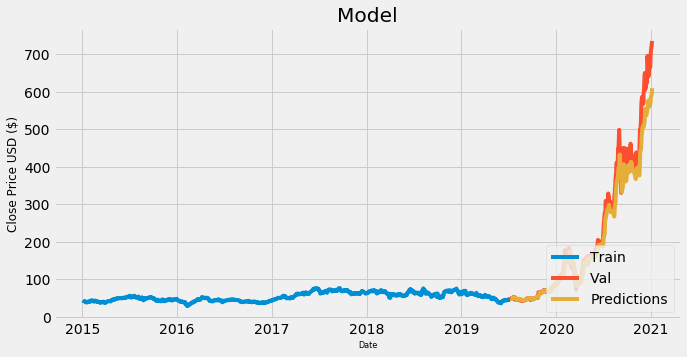

In [ ]:
# Visualising the results
train = data_target[:training_data_len]
valid = data_target[training_data_len:]
valid['Predictions'] = predicted_stock_price
plt.figure(figsize=(10,5))
plt.title('Model')
plt.xlabel('Date', fontsize=8)
plt.ylabel('Close Price USD ($)', fontsize=12)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
valid

,Close,Predictions
Date,,
2019-07-09,46.012001,47.117664
2019-07-10,47.784000,46.883499
2019-07-11,47.720001,47.420898
2019-07-12,49.015999,48.014587
2019-07-15,50.700001,48.840336
...,...,...
2020-12-29,665.989990,568.829102
2020-12-30,694.780029,573.007141
2020-12-31,705.669983,583.930786
